In [1]:
from matplotlib import pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler
from yaml import load as load_yaml, FullLoader

from dataset import KIDataset, train_test_split_stratified
from models.rocket import ROCKET
from processor.processor import Leif
from utils.const import SEED
from utils.data import binarize
from utils.misc import set_random_state
from utils.path import config_path

set_random_state(SEED)
!conda activate eyetrackpdc

# Data parameters
BINARY_CLF = True

# Rocket parameters
NUM_KERNELS = 1000
NORMALIZE = True

# Classifier parameters
REG_FACTOR = 1e5

## Initialize Datasets and Dataloaders

In [2]:
with open(f'{config_path}/leif.yaml', 'r') as reader:
    config = load_yaml(reader, Loader=FullLoader)

# Configure processor
processor = Leif(config)

# Initialize Datasets
train_val_ds = KIDataset(data_processor=processor, train=True)
train_ds, val_ds = train_test_split_stratified(train_val_ds, test_size=0.2)
test_ds = KIDataset(data_processor=processor, train=False)

# Binarize dataset after split to make sure split is stratified w.r.t all three classes
if BINARY_CLF:
    for ds in [train_ds, val_ds, test_ds]:
        binarize(ds)

# Initialize Dataloaders
train_dl = DataLoader(train_ds,
                      batch_size=train_ds.x.shape[0],
                      sampler=ImbalancedDatasetSampler(train_ds, callback_get_label=lambda item: item.y))
val_dl = DataLoader(val_ds, batch_size=val_ds.x.shape[0])
test_dl = DataLoader(test_ds, batch_size=test_ds.x.shape[0])

loaded dataset from C:\Users\hejpa\Documents\GitHub\eye-track-pdc\data\ki\tmp\ki-dataset-seg-train
loaded dataset from C:\Users\hejpa\Documents\GitHub\eye-track-pdc\data\ki\tmp\ki-dataset-seg-test


## Initialize Rocket and classifier

In [3]:
# Initialize Rocket
rocket = ROCKET(c_in=train_ds.x.shape[1],
                seq_len=train_ds.x.shape[2],
                n_kernels=NUM_KERNELS,
                normalize=NORMALIZE)

# Initialize Classifier
clf = RidgeClassifier(alpha=REG_FACTOR, random_state=SEED)

## Fit Model

In [4]:
# Batch is entire dataset
train_batch = next(iter(train_dl))

# Perform ROCKET transformation stage
features = rocket(train_batch.x)

# Fit Classifier
clf.fit(features, train_batch.y.numpy())

RidgeClassifier(alpha=100000.0, random_state=42)

## Evaluate on segment classification

Segment classification on test set:
              precision    recall  f1-score   support

          HC       0.47      0.66      0.55       121
          PD       0.80      0.64      0.71       253

    accuracy                           0.65       374
   macro avg       0.63      0.65      0.63       374
weighted avg       0.69      0.65      0.66       374



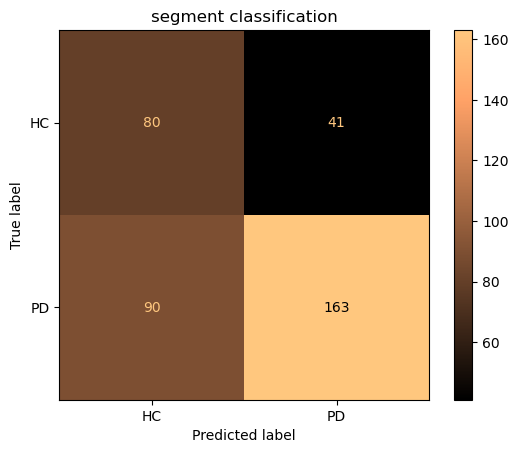

In [9]:
labels = ['HC', 'PD']
test_batch = next(iter(val_dl))

# Perform ROCKET transformation stage
test_features = rocket(test_batch.x)

# Make predictions on test set
pred = clf.predict(test_features)

# The RidgeClassifier maps the targets to {-1, 1}, but our labels are {0, 1}
pred[pred < 0] = 0

# Compute metrics
report = classification_report(test_batch.y.numpy(), pred, target_names=labels)

# Construct the confusion matrix
cf_matrix = confusion_matrix(test_batch.y, pred)

# Plot metrics and display confusion matrix
print(f'Segment classification on test set:\n{report}')
figure = ConfusionMatrixDisplay(cf_matrix, display_labels=labels).plot(cmap='copper')
figure.ax_.set_title('segment classification')
plt.show()

In [6]:
import numpy as np
from torch import sigmoid
import torch


# Only works for binary classification. Pass either logits or scores ~[0, 1].
def patient_soft_accuracy(*, segment_logits=None, segment_scores=None, y, z, threshold=0.2):
    unique, inv_idx = np.unique(z, return_inverse=True)
    patient_pred = np.zeros(unique.shape)
    patient_label = np.zeros(unique.shape)
    for i, p in enumerate(unique):
        patient_mask = z == unique[i]
        if segment_logits is not None:
            patient_segment_scores = sigmoid(torch.from_numpy(segment_logits[patient_mask])).numpy()
        elif segment_scores is not None:
            patient_segment_scores = segment_scores[patient_mask]
        else:
            raise ValueError("mandatory to pass segment scores or logits")
        mean_pred = np.mean(patient_segment_scores, axis=-1)
        patient_pred[i] = 1 if mean_pred > threshold else 0
        patient_label[i] = y[patient_mask][0]
    patient_acc = (patient_pred == patient_label).mean().item()
    return patient_pred, patient_label, patient_acc

In [12]:
p_pred, p_label, p_acc = patient_soft_accuracy(segment_scores=pred, y=test_batch.y, z=test_batch.z, threshold=0.43)
print(p_acc)

0.75
